In [1]:
from datasets import load_dataset

ds = load_dataset("bigcode/pii-for-code", split="train", use_auth_token=True)

Using custom data configuration bigcode--pii-for-code-3fe61a20f3bcbd4c


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset json downloaded and prepared to /Users/loubnabenallal/.cache/huggingface/datasets/bigcode___json/bigcode--pii-for-code-3fe61a20f3bcbd4c/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab. Subsequent calls will reuse this data.


In [27]:
import json

TAGS = ["EMAIL", "IP_ADDRESS", "SSH_KEY", "API_KEY", "NAME", "USERNAME", "PASSWORD", "AMBIGUOUS"]

def get_pii_list(ds):
    list_pii = []
    for example in ds:
        pii = json.loads(example["pii"])
        for sample in pii:
            list_pii.append(sample)
    return list_pii

def get_pii_stats(list_pii):
    stats = {}
    values = {}
    for tag in TAGS:
        stats[tag] = 0
        values[tag] = []
    # iterate over list of pii and count the number of times we see each tag
    for sample in list_pii:
        for tag in TAGS:
            if tag == sample["tag"]:
                stats[tag] += 1
                values[tag].append(sample["value"])
    return {"stats": stats, "values": values}

In [49]:
list_pii = get_pii_list(ds)
stats = get_pii_stats(list_pii)
print(len(list_pii))

1154


In [50]:
# append lists in values with empty strings to have the same length in all tags
# make a deepcopy of values to avoid modifying the original list
import copy

values = copy.deepcopy(stats["values"])
max_len = max([len(values[tag]) for tag in TAGS])
for tag in TAGS:
    values[tag] += [""] * (max_len - len(values[tag]))

In [51]:
# build hf datasets from values
import pandas as pd
import datasets

df = pd.DataFrame(values)
dataset = datasets.Dataset.from_pandas(df)

In [53]:
dataset

Dataset({
    features: ['EMAIL', 'IP_ADDRESS', 'SSH_KEY', 'API_KEY', 'NAME', 'USERNAME', 'PASSWORD', 'AMBIGUOUS'],
    num_rows: 369
})

In [54]:
dataset.push_to_hub("loubnabnl/pii-instances")

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

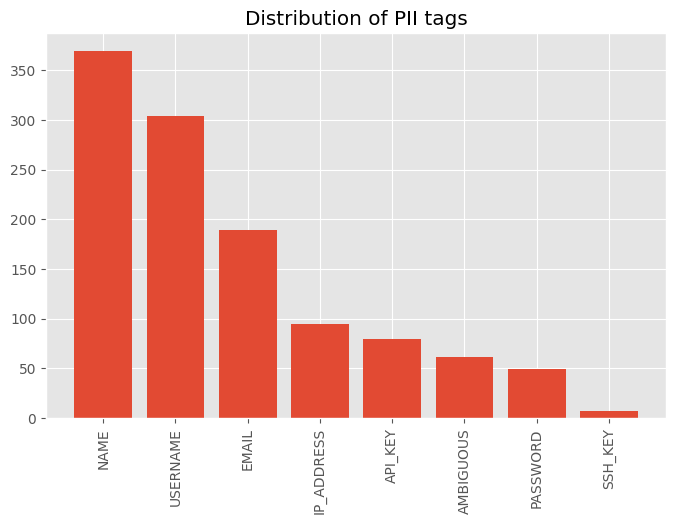

In [42]:
# plot distibution of tags
import matplotlib.pyplot as plt
# use ggplot style defaults and set the default figure size
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8, 5)
# sort stats by value descending
sorted_stats = {k: v for k, v in sorted(stats["stats"].items(), key=lambda item: item[1], reverse=True)}
plt.bar(sorted_stats.keys(), sorted_stats.values())
# add title to the plot
plt.title("Distribution of PII tags")
# rotate xlabels
plt.xticks(rotation=90)
# use black ticks
#plt.tick_params(colors='black')
plt.show()
